# "Longevity of the south paws"
> "How to use Bayesian Statistics to determine how left handers and their longevity change over time"

- toc: true
- badges: true
- image: https://i.imgur.com/gBIWykY.png
- comments: true 
- author: Jordan Wilheim
- categories: [bayesian, python, eda, cleaning, statistics, bootstrapping]

## Do Left Handed People Die Younger?

In this notebook, we will explore this phenomenon using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates of left-handedness over time, refuting the claim of early death for left-handers. This notebook uses `pandas` and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed

 National Geographic survey in 1986 resulted in over a million responses that included age, sex, and hand preference for throwing and writing. Researchers Avery Gilbert and Charles Wysocki analyzed this data and noticed that rates of left-handedness were around 13% for people younger than 40 but decreased with age to about 5% by the age of 80. They concluded based on analysis of a subgroup of people who throw left-handed but write right-handed that this age-dependence was primarily due to changing social acceptability of left-handedness. This means that the rates aren't a factor of _age_ specifically but rather of the _year you were born_, and if the same study was done today, we should expect a shifted version of the same distribution as a function of age. Ultimately, we'll see what effect this changing rate has on the apparent mean age of death of left-handed people, but let's start by plotting the rates of left-handedness as a function of age.

This notebook uses two datasets: 
1. [death distribution data](https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf) for the United States from the year 1999 by the CDC
2. [rates of left handedness](https://www.ncbi.nlm.nih.gov/pubmed/1528408) digitized from a figure in this 1992 paper by Gilbert and Wysocki 



In [206]:
#collapse
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import seaborn as sns
sns.set()

# load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

In [207]:
#collapse
left_vis = ( lefthanded_data
            .melt(id_vars=['Age'], var_name='Gender', value_name='Percentage of people who are left-handed')
           ) 

dots = alt.Chart(left_vis).mark_point().encode(
    x='Age:Q', 
    y=alt.Y('Percentage of people who are left-handed:Q', axis=alt.Axis(title='Percentage of people who are left-handed')),
    color='Gender:N')

dots

alt.Chart(...)

## Rates of left-handedness over time
<p>Let's convert this data into a plot of the rates of left-handedness as a function of the year of birth, and average over male and female to get a single rate for both sexes. </p>
<p>Since the study was done in 1986, the data after this conversion will be the percentage of people alive in 1986 who are left-handed as a function of the year they were born. </p>

In [208]:
#collapse
lefthanded_data['Birth Year'] = pd.to_datetime(1986 - lefthanded_data['Age'], format="%Y")

lefthanded_data['L_Percent'] = lefthanded_data[['Female', 'Male']].mean(axis=1) / 100


chart = alt.Chart(lefthanded_data).mark_area().encode(
    x='Birth Year:T', 
    y=alt.Y('L_Percent:Q', axis=alt.Axis(format='%', title='Percentage of people who are left-handed'))
)

chart

alt.Chart(...)

In [209]:
lefthanded_data['Birth Year'] = lefthanded_data['Birth Year'].dt.year

## Applying Bayes' rule
<p>The probability of dying at a certain age given that you're left-handed is <strong>not</strong> equal to the probability of being left-handed given that you died at a certain age. This inequality is why we need <strong>Bayes' theorem</strong>, a statement about conditional probability which allows us to update our beliefs after seeing evidence. </p>
<p>We want to calculate the probability of dying at age A given that you're left-handed. Let's write this in shorthand as P(A | LH). We also want the same quantity for right-handers: P(A | RH). </p>
<p>Here's Bayes' theorem for the two events we care about: left-handedness (LH) and dying at age A.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>P(LH | A) is the probability that you are left-handed <em>given that</em> you died at age A. P(A) is the overall probability of dying at age A, and P(LH) is the overall probability of being left-handed. We will now calculate each of these three quantities, beginning with P(LH | A).</p>
<p>To calculate P(LH | A) for ages that might fall outside the original data, we will need to extrapolate the data to earlier and later years. Since the rates flatten out in the early 1900s and late 1900s, we'll use a few points at each end and take the mean to extrapolate the rates on each end. The number of points used for this is arbitrary, but we'll pick 10 since the data looks flat-ish until about 1910. </p>


$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$

In [210]:
# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data.loc[lefthanded_data['Birth Year'].sort_values().head(10).index, 'L_Percent'].mean()
    late_1900s_rate = lefthanded_data.loc[lefthanded_data['Birth Year'].sort_values(ascending=False).head(10).index, 'L_Percent'].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth Year'].isin(study_year - ages_of_death)]['L_Percent']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] =  early_1900s_rate
    P_return[ages_of_death < youngest_age] = late_1900s_rate 
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates 
    
    return P_return

## When do people normally die?
<p>To estimate the probability of living to an age A, we can use data that gives the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution that gives the probability of dying at age A. The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. </p>
<p>In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age. </p>

In [211]:
#collapse
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])
# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.rename({"Both Sexes": "Total Deaths"}, axis=1)

death_distribution_data = death_distribution_data.loc[~death_distribution_data["Total Deaths"].isna()]

( alt
 .Chart(death_distribution_data)
 .mark_area()
 .encode(x='Age:Q', y='Total Deaths:Q')
)

alt.Chart(...)

## The overall probability of left-handedness
<p>In the previous code block we loaded data to give us P(A), and now we need P(LH). P(LH) is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where N(A) is the number of people who died at age A (given by the dataframe <code>death_distribution_data</code>):</p>
<p><img src="https://i.imgur.com/gBIWykY.png" alt="equation" width="220"></p>
<!--- $$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$ -->

In [212]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    p_list = P_lh_given_A(death_distribution_data['Age'], study_year=study_year) * death_distribution_data['Total Deaths'] # multiply number of dead people by P_lh_given_A
    p = sum(p_list)
    return p / sum(death_distribution_data['Total Deaths']) # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

print(f"The probability of being left handed is: {P_lh(death_distribution_data):.2%}")

The probability of being left handed is: 7.77%


## Putting it all together: dying while left-handed (i)
<p>Now we have the means of calculating all three quantities we need: P(A), P(LH), and P(LH | A). We can combine all three using Bayes' rule to get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to P(A | RH), the probability of being age A at death given that you're right-handed. </p>
<p>We're calculating the following quantity twice, once for left-handers and once for right-handers.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>First, for left-handers.</p>
<!--Notice that I was careful not to call these "probability of dying at age A", since that's not actually what we're calculating: we use the exact same death distribution data for each. -->

In [1]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Total Deaths'][ages_of_death] / np.sum(death_distribution_data['Total Deaths'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

## Putting it all together: dying while left-handed (ii)
<p>And now for right-handers.</p>

In [214]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Total Deaths'][ages_of_death] / np.sum(death_distribution_data['Total Deaths'])
    P_right = 1 - P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year) # P_rh_A = 1 - P_lh_A 
    return P_rh_A*P_A/P_right


def make_prob_df(series: "pandas series", hand: str) -> "pandas dataframe":
    df = ( pd.DataFrame(series)
          .reset_index()
          .assign(Handedness=hand)
          .rename({"Total Deaths" : "Probability", "index" : "Age at Death"}, axis=1)
         
         )
    return df

## Plotting the distributions of conditional probabilities
<p>Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120. </p>
<p>Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger. </p>

In [215]:
ages = np.arange(6, 115, 1) # make a list of ages of death to plot

# calculate the probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)
right_left_df = pd.concat( [ make_prob_df(right_handed_probability, 'Right'), make_prob_df(left_handed_probability, 'Left')])

In [216]:
#collapse

death_prob_90 = ( alt.Chart(right_left_df, title='1990 Distribution')
    .mark_area(opacity=0.3)
    .encode(x='Age at Death:Q', y='Probability:Q', color='Handedness:N') ) 

death_prob_90

alt.Chart(...)

## Moment of truth: age of left and right-handers at death
<p>Finally, let's compare our results with the original study that found that left-handed people were nine years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated P(LH) earlier, weighting the probability distribution by age and summing over the result.</p>
<p>$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$</p>
<p>$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$</p>

In [217]:
right_left_df['Average Age of Death (Years)'] = right_left_df['Age at Death'] * right_left_df['Probability']
handed_probs = right_left_df.groupby('Handedness')['Average Age of Death (Years)'].sum()
print(handed_probs.round(2))
print(f"\n\nThe difference in average age of death between left and right handed people are: {handed_probs.diff().values[-1]:.2f} years.")

Handedness
Left     67.25
Right    72.79
Name: Average Age of Death (Years), dtype: float64


The difference in average age of death between left and right handed people are: 5.55 years.


In [218]:
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 1)) + " years.")

The difference in average ages is -5.5 years.


## Final comments
<p>We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: you probably won't die young because of your sinisterness. The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers.</p>
<p>Our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: </p>
<ol>
<li>We used death distribution data from almost ten years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). </li>
<li>We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. </li>
</ol>

In [219]:
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, 2018)
right_left_2018_df = pd.concat( [ make_prob_df(right_handed_probability_2018, 'Right'), make_prob_df(left_handed_probability_2018, 'Left')])

In [220]:
#collapse
death_prob_2018 = ( alt.Chart(right_left_2018_df, title='2018 Distribution')
    .mark_area(opacity=0.3)
    .encode(x='Age at Death:Q', y='Probability:Q', color='Handedness:N' )
                  )

death_prob_90 | death_prob_2018

alt.HConcatChart(...)

In [221]:
right_left_2018_df['Average Age of Death (Years)'] = right_left_2018_df['Age at Death'] * right_left_2018_df['Probability']
handed_probs = right_left_2018_df.groupby('Handedness')['Average Age of Death (Years)'].sum()
print(handed_probs.round(2))
print(f"\n\nThe difference in average age of death between left and right handed people are: {handed_probs.diff().values[-1]:.2f} years.")

Handedness
Left     70.29
Right    72.63
Name: Average Age of Death (Years), dtype: float64


The difference in average age of death between left and right handed people are: 2.34 years.


In order to determine if there are significant differences between these distributions, we can use a simulation. 

We can use a 95% confidence interval to 

In [283]:
sim_age_2018 = ( np.random.choice(right_left_2018_df['Average Age of Death (Years)'].values, size=(10000, int(right_left_2018_df.shape[0]/2))) ).sum(axis=1)

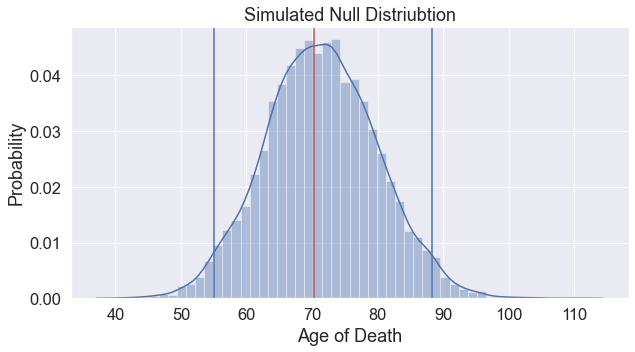

In [284]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=[10,5])
    sns.distplot(sim_age_2018)
    plt.title("Simulated Null Distriubtion")
    plt.axvline(x=handed_probs['Left'], c='r')
    plt.axvline(x=np.percentile(sim_age_2018, q=2.5))
    plt.axvline(x=np.percentile(sim_age_2018, q=97.5))
    plt.xlabel("Age of Death")
    plt.ylabel("Probability")

In [285]:
lower, upper = np.percentile(sim_age_2018, q=[2.5, 97.5]).round(2)
print(f"The Simulated Null Distriubtion has a confidence interval of {lower} to {upper} years" )


The Simulated Null Distriubtion has a confidence interval of 55.0 to 88.36 years


Based on our 95% confidence interval, we can't say that there's a significant difference between Left hand and Right Hand death ages. 